In [1]:
print ("check")

check


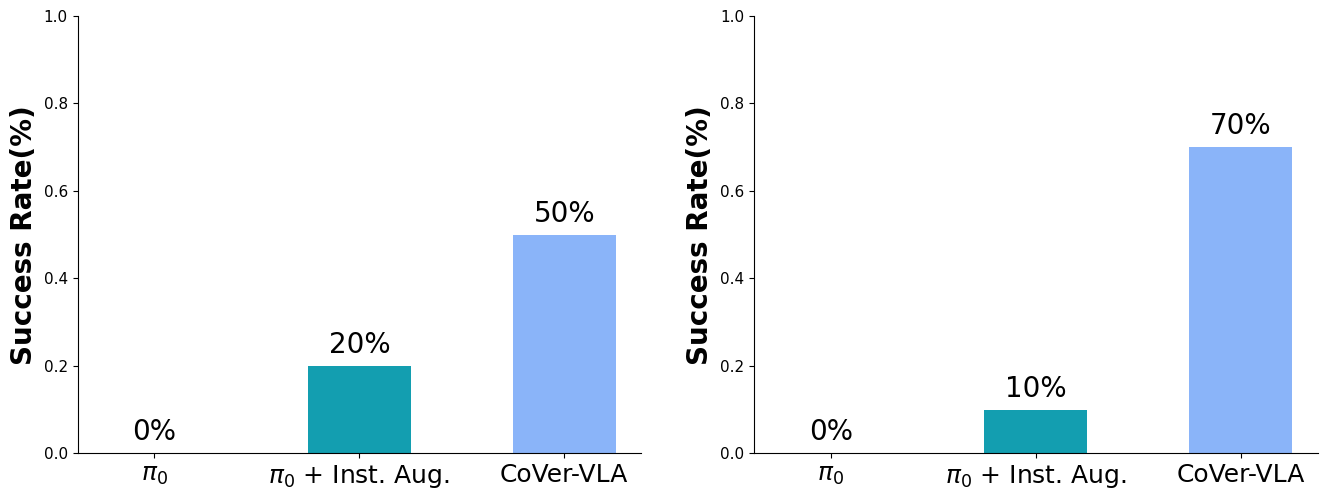

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec


def draw_dots_on_image(
    img,
    start_xy,
    end_xy,
    n=20,
    cmap="plasma",
    radius=28,     # MUCH bigger circles
    alpha=1.0
):
    """
    Draw perfectly clean circular dots along a curved Bézier path.
    No glow, no squares, no blending artifacts.
    """

    p0 = np.array(start_xy)
    p2 = np.array(end_xy)

    # -------------------------
    # Quadratic Bézier curve
    # -------------------------
    mid = (p0 + p2) / 2
    offset = np.array([-(p2[1]-p0[1]), (p2[0]-p0[0])]) * 0.25
    p1 = mid + offset

    t = np.linspace(0, 1, n)
    xs = (1-t)**2 * p0[0] + 2*(1-t)*t * p1[0] + t**2 * p2[0]
    ys = (1-t)**2 * p0[1] + 2*(1-t)*t * p1[1] + t**2 * p2[1]

    cmap_fn = plt.get_cmap(cmap)
    colors = cmap_fn(np.linspace(0, 1, n))[:, :3]

    H, W = img.shape[:2]

    for (x, y), color in zip(zip(xs, ys), colors):
        cx, cy = int(x), int(y)

        # Create a circle mask
        yy, xx = np.ogrid[-radius:radius, -radius:radius]
        mask_circle = (xx*xx + yy*yy) <= radius * radius

        y1, y2 = cy - radius, cy + radius
        x1, x2 = cx - radius, cx + radius

        # Bounds check
        if y1 < 0 or y2 >= H or x1 < 0 or x2 >= W:
            continue

        patch = img[y1:y2, x1:x2]

        # Only overwrite circle pixels
        circle = patch.copy()
        circle[mask_circle] = color

        img[y1:y2, x1:x2] = circle

    return img




# =====================================================
# Data
# =====================================================
tasks = ["Pepto Bismol on Plate", "Redbull on Plate"]

models = [
    r"$\pi_0$",
    r"$\pi_0$ + Inst. Aug.",
    r"CoVer-VLA"
]

values = {
    "Pepto Bismol on Plate": [0.0, 0.2, 0.5],
    "Redbull on Plate": [0.0, 0.1, 0.7]
}

task_images_base = {
    "Pepto Bismol on Plate": "pepto-bismo_real-world.png",
    "Redbull on Plate": "redbull_real-world.png"
}
task_images_cover = {
    "Pepto Bismol on Plate": "pepto-bismo_real-world.png",
    "Redbull on Plate": "redbull_real-world.png"
}

# task_images_base = {
#     "Pepto Bismol on Plate": "pepto_real.jpg",
#     "Redbull on Plate": "red_bull_real.jpg"
# }
# task_images_cover = {
#     "Pepto Bismol on Plate": "pepto_real.jpg",
#     "Redbull on Plate": "red_bull_real.jpg"
# }

coords = {
    "Pepto Bismol on Plate": {
        "base":  {"start": (500, 400), "end": (800, 550)},
        "cover": {"start": (500, 400), "end": (180, 600)}
    },
    "Redbull on Plate": {
        "base":  {"start": (670, 450), "end": (500, 600)},
        "cover": {"start": (670, 450), "end": (800, 650)}
    }
}

# =====================================================
# Figure Layout
# =====================================================
num_tasks = len(tasks)
fig = plt.figure(figsize=(8*num_tasks, 10))
gs = GridSpec(2, num_tasks, height_ratios=[2.5, 1.5], figure=fig)

for col, task in enumerate(tasks):

    # ---------------- BAR CHART ----------------
    ax_bar = fig.add_subplot(gs[0, col])
    vals = values[task]

    ax_bar.bar(np.arange(len(models)), vals, color=["#333333", "#139EB0", "#8AB4F9"], width=0.5)
    ax_bar.set_xticks(np.arange(len(models)))
    ax_bar.set_xticklabels(models, ha='center', fontsize=18)
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Success Rate(%)", fontsize=20, fontweight="bold")
    # ax_bar.set_title(task, fontsize=20)

    for i, v in enumerate(vals):
        ax_bar.text(i, v + 0.03, f"{int(v*100)}%", ha='center', fontsize=20)

    # # ---------------- IMAGE PANELS ----------------
    # inner_gs = GridSpec(
    #     1, 2, figure=fig,
    #     left=ax_bar.get_position().x0,
    #     right=ax_bar.get_position().x1,
    #     bottom=0.05,
    #     top=0.35
    # )

    # BASE policy image
    # ax_img1 = fig.add_subplot(inner_gs[0, 0])
    # img1 = mpimg.imread(task_images_base[task]).copy()
    # s = coords[task]["base"]["start"]
    # e = coords[task]["base"]["end"]
    # img1 = draw_dots_on_image(img1, s, e, n=20, cmap="plasma")
    # ax_img1.imshow(img1)
    # ax_img1.axis("off")
    # ax_img1.set_title(r"$\pi_0$ w/ Inst. Aug.", fontsize=22)

    # COVER policy image
    # ax_img2 = fig.add_subplot(inner_gs[0, 1])
    # img2 = mpimg.imread(task_images_cover[task]).copy()
    # s = coords[task]["cover"]["start"]
    # e = coords[task]["cover"]["end"]
    # img2 = draw_dots_on_image(img2, s, e, n=20, cmap="plasma")
    # ax_img2.imshow(img2)
    # ax_img2.axis("off")
    # ax_img2.set_title("CoVer-VLA", fontsize=22)

# plt.savefig("two_images_side_by_side_per_task_ANNOTATED.png", dpi=600, bbox_inches='tight')
plt.show()


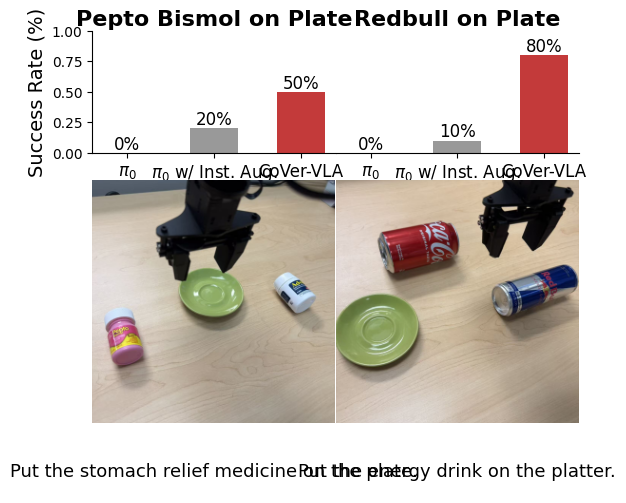

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.patches import FancyBboxPatch
from matplotlib.gridspec import GridSpec
import cv2


# =====================================================
# DeepMind-style preprocess
# =====================================================
def dm_preprocess(img, out_size=256):
    h, w = img.shape[:2]
    side = min(h, w)
    top = (h - side) // 2
    left = (w - side) // 2
    cropped = img[top:top+side, left:left+side]
    return cv2.resize(cropped, (out_size, out_size), interpolation=cv2.INTER_AREA)


def dm_show(ax, img):
    ax.axis("off")
    ax.imshow(img)
    h, w = img.shape[:2]
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)


# =====================================================
# Data
# =====================================================
tasks = ["Pepto Bismol on Plate", "Redbull on Plate"]
models = [r"$\pi_0$", r"$\pi_0$ w/ Inst. Aug.", r"CoVer-VLA"]

values = {
    "Pepto Bismol on Plate": [0.0, 0.2, 0.5],
    "Redbull on Plate": [0.0, 0.1, 0.8]
}

task_images_cover = {
    "Pepto Bismol on Plate": "pepto_plot.jpg",
    "Redbull on Plate": "red_bull_real.jpg"
}

task_instructions = {
    "Pepto Bismol on Plate": "Put the stomach relief medicine on the plate.",
    "Redbull on Plate": "Put the energy drink on the platter."
}


# =====================================================
# Layout
# =====================================================
fig = plt.figure(figsize=(12,6))
gs = GridSpec(
    3, 2,
    height_ratios=[1.0, 2.0, 0.35],   # plots, images, instructions
    hspace=0.20,
    wspace=0.0
)

axes_plot = []
axes_img = []
axes_text = []


# ------------------ ROW 0: BAR PLOTS ------------------
for col, task in enumerate(tasks):
    ax = fig.add_subplot(gs[0, col])
    axes_plot.append(ax)

    vals = values[task]
    ax.bar(np.arange(len(models)), vals,
           color=["#4A4A4A","#999999","#C33A3A"], width=0.55)

    ax.set_title(task, fontsize=16, fontweight="bold", pad=4)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylim(0,1.0)

    if col == 0:
        ax.set_ylabel("Success Rate (%)", fontsize=14)
    else:
        ax.spines["left"].set_visible(False)
        ax.set_yticks([])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for i,v in enumerate(vals):
        ax.text(i, v+0.03, f"{int(v*100)}%", ha="center", fontsize=12)


# ------------------ ROW 1: IMAGES ------------------
for col, task in enumerate(tasks):
    ax_img = fig.add_subplot(gs[1, col])
    axes_img.append(ax_img)
    raw = mpimg.imread(task_images_cover[task])
    img = dm_preprocess(raw, 256)
    dm_show(ax_img, img)


# ------------------ ROW 2: INSTRUCTIONS ------------------
for col, task in enumerate(tasks):
    ax_txt = fig.add_subplot(gs[2, col])
    axes_text.append(ax_txt)
    ax_txt.axis("off")
    ax_txt.text(
        0.5, 0.5,
        task_instructions[task],
        ha="center", va="center",
        fontsize=13
    )


# =====================================================
# ⭐ CRITICAL PART: FORCE GLOBAL COLUMN ALIGNMENT
# =====================================================
fig.canvas.draw()

# Use the LEFT image x0 as the canonical left column start
LEFT_X0 = axes_img[0].get_position().x0
WIDTH = axes_img[0].get_position().width

RIGHT_X0 = LEFT_X0 + WIDTH   # second column starts immediately after first

# Apply these boundaries to all 3 rows
for ax in [axes_plot[0], axes_img[0], axes_text[0]]:
    p = ax.get_position()
    ax.set_position([LEFT_X0, p.y0, WIDTH, p.height])

for ax in [axes_plot[1], axes_img[1], axes_text[1]]:
    p = ax.get_position()
    ax.set_position([RIGHT_X0, p.y0, WIDTH, p.height])


plt.show()


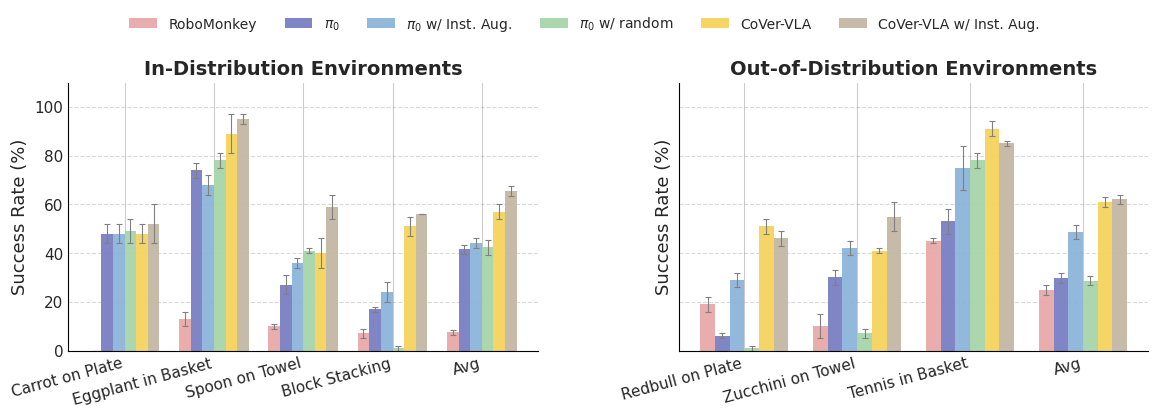

In [11]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ============================================================
# Font setup
# ============================================================
available_fonts = [f.name for f in fm.fontManager.ttflist]
if "Helvetica" in available_fonts:
    font_family = "Helvetica"
elif "Arial" in available_fonts:
    font_family = "Arial"
else:
    font_family = "DejaVu Sans"

plt.rcParams.update({
    "font.family": font_family,
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
})

# ============================================================
# Colors (Physical-Intelligence style)
# ============================================================
colors = [
    "#E8A9A9",  # RoboMonkey (baseline)
    "#7980C2",  # π0
    "#8CB4D9",  # π0 w/ Inst. Aug.
    "#A7D5AB",  # π0 w/ random
    "#F4D35E",  # CoVer-VLA
    "#C2B8A3"   # CoVer-VLA w/ Inst. Aug.
]

# ============================================================
# Data
# ============================================================
models = [
    r"RoboMonkey",
    r"$\pi_0$",
    r"$\pi_0$ w/ Inst. Aug.",
    r"$\pi_0$ w/ random",
    r"CoVer-VLA",
    r"CoVer-VLA w/ Inst. Aug."
]

in_tasks = ["Carrot on Plate", "Eggplant in Basket", "Spoon on Towel", "Block Stacking", "Avg"]
out_tasks = ["Redbull on Plate", "Zucchini on Towel", "Tennis in Basket", "Avg"]

in_means = np.array([
    [ 0, 13, 10,  7,  7.5],
    [48, 74, 27, 17, 41.5],
    [48, 68, 36, 24, 44.0],
    [49, 78, 41,  1, 42.3],
    [48, 89, 40, 51, 57.0],
    [52, 95, 59, 56, 65.5],
])
in_stds = np.array([
    [0, 3, 1, 2, 1],
    [4, 3, 4, 1, 2],
    [4, 4, 2, 4, 2],
    [5, 3, 1, 1, 3],
    [4, 8, 6, 4, 3],
    [8, 2, 5, 0, 2],
])

out_means = np.array([
    [19, 10, 45, 24.7],
    [ 6, 30, 53, 29.7],
    [29, 42, 75, 48.7],
    [ 1,  7, 78, 28.7],
    [51, 41, 91, 61.0],
    [46, 55, 85, 62.0],
])
out_stds = np.array([
    [3, 5, 1, 2],
    [1, 3, 5, 2],
    [3, 3, 9, 3],
    [1, 2, 3, 2],
    [3, 1, 3, 2],
    [3, 6, 1, 2],
])

# ============================================================
# Plot helper
# ============================================================
def plot_env(ax, tasks, means, stds, title, show_legend=False):
    n_models, n_tasks = means.shape
    x = np.arange(n_tasks)
    width = 0.13

    for i in range(n_models):
        offset = (i - (n_models - 1) / 2) * width
        ax.bar(
            x + offset, means[i], width,
            yerr=stds[i],
            color=colors[i],
            capsize=2,
            alpha=0.95,
            error_kw=dict(lw=0.8, capthick=0.8, ecolor="gray"),
            label=models[i] if show_legend else None
        )

    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=15, ha="right")
    ax.set_ylim(0, 110)
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(title, fontsize=14, weight="bold")
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.3)
    ax.set_facecolor("white")

# ============================================================
# 5. Balanced layout + single-row legend
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, gridspec_kw={"wspace": 0.3})

plot_env(axes[0], in_tasks, in_means, in_stds, "In-Distribution Environments", show_legend=True)
plot_env(axes[1], out_tasks, out_means, out_stds, "Out-of-Distribution Environments")

# Move legend above both subplots in one row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(models), loc="upper center", bbox_to_anchor=(0.5, 1.05))

plt.subplots_adjust(left=0.07, right=0.97, top=0.85, bottom=0.18, wspace=0.35)
plt.show()





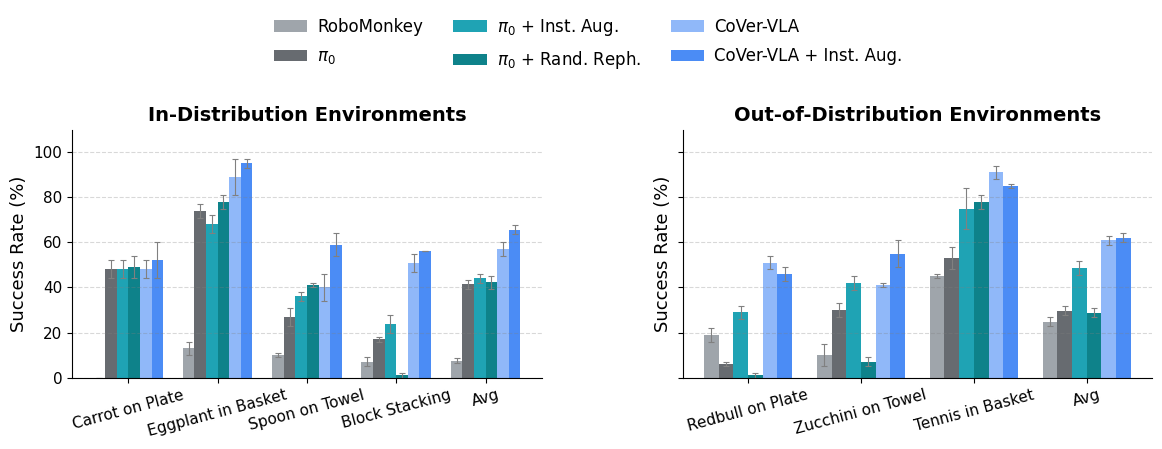

<Figure size 640x480 with 0 Axes>

In [9]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ============================================================
# Font setup
# ============================================================
available_fonts = [f.name for f in fm.fontManager.ttflist]
if "Helvetica" in available_fonts:
    font_family = "Helvetica"
elif "Arial" in available_fonts:
    font_family = "Arial"
else:
    font_family = "DejaVu Sans"

plt.rcParams.update({
    "font.family": font_family,
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
})

# ============================================================
# Colors (Physical-Intelligence style)
# ============================================================
colors = [
    "#9AA0A7",  # RoboMonkey (baseline)
    "#5F6368",  # π0
    "#139EB0",  # π0 w/ Inst. Aug.
    "#017B84",  # π0 w/ random
    "#8AB4F9",  # CoVer-VLA
    "#4186F5"   # CoVer-VLA w/ Inst. Aug.
]

# ============================================================
# Data
# ============================================================
models = [
    r"RoboMonkey",
    r"$\pi_0$",
    r"$\pi_0$ + Inst. Aug.",
    r"$\pi_0$ + Rand. Reph.",
    r"CoVer-VLA",
    r"CoVer-VLA + Inst. Aug."
]

in_tasks = ["Carrot on Plate", "Eggplant in Basket", "Spoon on Towel", "Block Stacking", "Avg"]
out_tasks = ["Redbull on Plate", "Zucchini on Towel", "Tennis in Basket", "Avg"]

in_means = np.array([
    [ 0, 13, 10,  7,  7.5],
    [48, 74, 27, 17, 41.5],
    [48, 68, 36, 24, 44.0],
    [49, 78, 41,  1, 42.3],
    [48, 89, 40, 51, 57.0],
    [52, 95, 59, 56, 65.5],
])
in_stds = np.array([
    [0, 3, 1, 2, 1],
    [4, 3, 4, 1, 2],
    [4, 4, 2, 4, 2],
    [5, 3, 1, 1, 3],
    [4, 8, 6, 4, 3],
    [8, 2, 5, 0, 2],
])

out_means = np.array([
    [19, 10, 45, 24.7],
    [ 6, 30, 53, 29.7],
    [29, 42, 75, 48.7],
    [ 1,  7, 78, 28.7],
    [51, 41, 91, 61.0],
    [46, 55, 85, 62.0],
])
out_stds = np.array([
    [3, 5, 1, 2],
    [1, 3, 5, 2],
    [3, 3, 9, 3],
    [1, 2, 3, 2],
    [3, 1, 3, 2],
    [3, 6, 1, 2],
])

# ============================================================
# Plot helper
# ============================================================
def plot_env(ax, tasks, means, stds, title, show_legend=False):
    n_models, n_tasks = means.shape
    x = np.arange(n_tasks)
    width = 0.13

    for i in range(n_models):
        offset = (i - (n_models - 1) / 2) * width
        ax.bar(
            x + offset, means[i], width,
            yerr=stds[i],
            color=colors[i],
            capsize=2,
            alpha=0.95,
            error_kw=dict(lw=0.8, capthick=0.8, ecolor="gray"),
            label=models[i] if show_legend else None
        )

    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=15, ha="center")
    ax.set_ylim(0, 110)
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(title, fontsize=14, weight="bold")
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.3)
    ax.set_facecolor("white")

# ============================================================
# 5. Balanced layout + single-row legend
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, gridspec_kw={"wspace": 0.3})

plot_env(axes[0], in_tasks, in_means, in_stds, "In-Distribution Environments", show_legend=True)
plot_env(axes[1], out_tasks, out_means, out_stds, "Out-of-Distribution Environments")

# # Move legend above both subplots in one row
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncol=len(models), loc="upper center", bbox_to_anchor=(0.5, 1.05))
# Move legend above both subplots in multi-column grid
handles, labels = axes[0].get_legend_handles_labels()

# Arrange legend manually in two columns, three rows
order = [0, 1, 2, 3, 4, 5]  # keep order consistent with models
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,                   # two columns
    columnspacing=1.8,
    handletextpad=0.6,
    labelspacing=0.7,
    fontsize=12,
    frameon=False,
)

plt.subplots_adjust(left=0.07, right=0.97, top=0.80, bottom=0.18, wspace=0.35)
plt.show()


plt.subplots_adjust(left=0.07, right=0.97, top=0.85, bottom=0.18, wspace=0.35)
plt.show()



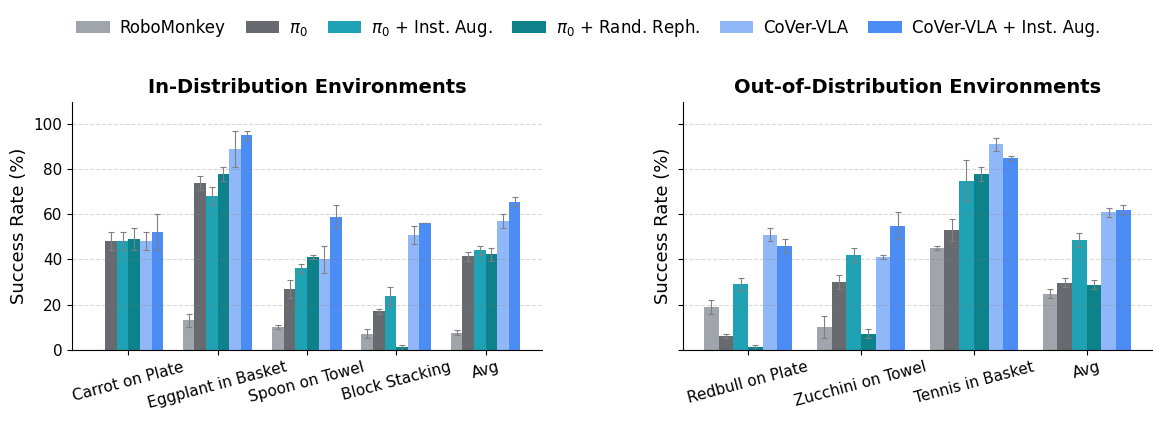

In [51]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ============================================================
# Font setup
# ============================================================
available_fonts = [f.name for f in fm.fontManager.ttflist]
if "Helvetica" in available_fonts:
    font_family = "Helvetica"
elif "Arial" in available_fonts:
    font_family = "Arial"
else:
    font_family = "DejaVu Sans"

plt.rcParams.update({
    "font.family": font_family,
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
})

# ============================================================
# Colors (Physical-Intelligence style)
# ============================================================
colors = [
    "#9AA0A7",  # RoboMonkey (baseline)
    "#5F6368",  # π0
    "#139EB0",  # π0 w/ Inst. Aug.
    "#017B84",  # π0 w/ random
    "#8AB4F9",  # CoVer-VLA
    "#4186F5"   # CoVer-VLA w/ Inst. Aug.
]

# ============================================================
# Data
# ============================================================
models = [
    r"RoboMonkey",
    r"$\pi_0$",
    r"$\pi_0$ + Inst. Aug.",
    r"$\pi_0$ + Rand. Reph.",
    r"CoVer-VLA",
    r"CoVer-VLA + Inst. Aug."
]

in_tasks = ["Carrot on Plate", "Eggplant in Basket", "Spoon on Towel", "Block Stacking", "Avg"]
out_tasks = ["Redbull on Plate", "Zucchini on Towel", "Tennis in Basket", "Avg"]

in_means = np.array([
    [ 0, 13, 10,  7,  7.5],
    [48, 74, 27, 17, 41.5],
    [48, 68, 36, 24, 44.0],
    [49, 78, 41,  1, 42.3],
    [48, 89, 40, 51, 57.0],
    [52, 95, 59, 56, 65.5],
])
in_stds = np.array([
    [0, 3, 1, 2, 1],
    [4, 3, 4, 1, 2],
    [4, 4, 2, 4, 2],
    [5, 3, 1, 1, 3],
    [4, 8, 6, 4, 3],
    [8, 2, 5, 0, 2],
])

out_means = np.array([
    [19, 10, 45, 24.7],
    [ 6, 30, 53, 29.7],
    [29, 42, 75, 48.7],
    [ 1,  7, 78, 28.7],
    [51, 41, 91, 61.0],
    [46, 55, 85, 62.0],
])
out_stds = np.array([
    [3, 5, 1, 2],
    [1, 3, 5, 2],
    [3, 3, 9, 3],
    [1, 2, 3, 2],
    [3, 1, 3, 2],
    [3, 6, 1, 2],
])

# ============================================================
# Plot helper
# ============================================================
def plot_env(ax, tasks, means, stds, title, show_legend=False):
    n_models, n_tasks = means.shape
    x = np.arange(n_tasks)
    width = 0.13

    for i in range(n_models):
        offset = (i - (n_models - 1) / 2) * width
        ax.bar(
            x + offset, means[i], width,
            yerr=stds[i],
            color=colors[i],
            capsize=2,
            alpha=0.95,
            error_kw=dict(lw=0.8, capthick=0.8, ecolor="gray"),
            label=models[i] if show_legend else None
        )

    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=15, ha="center")
    ax.set_ylim(0, 110)
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(title, fontsize=14, weight="bold")
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.3)
    ax.set_facecolor("white")

# ============================================================
# 5. Balanced layout + single-row legend
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, gridspec_kw={"wspace": 0.3})

plot_env(axes[0], in_tasks, in_means, in_stds, "In-Distribution Environments", show_legend=True)
plot_env(axes[1], out_tasks, out_means, out_stds, "Out-of-Distribution Environments")

# # Move legend above both subplots in one row
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncol=len(models), loc="upper center", bbox_to_anchor=(0.5, 1.05))
# Move legend above both subplots in multi-column grid
handles, labels = axes[0].get_legend_handles_labels()

# Arrange legend manually in two columns, three rows
order = [0, 1, 2, 3, 4, 5]  # keep order consistent with models
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=6,                   # two columns
    columnspacing=1.2,
    handletextpad=0.6,
    labelspacing=0.7,
    fontsize=12,
    frameon=False,
)

plt.subplots_adjust(left=0.07, right=0.97, top=0.80, bottom=0.18, wspace=0.35)
plt.savefig("plot.pdf", bbox_inches="tight")  # save current figure as PDF
plt.show()



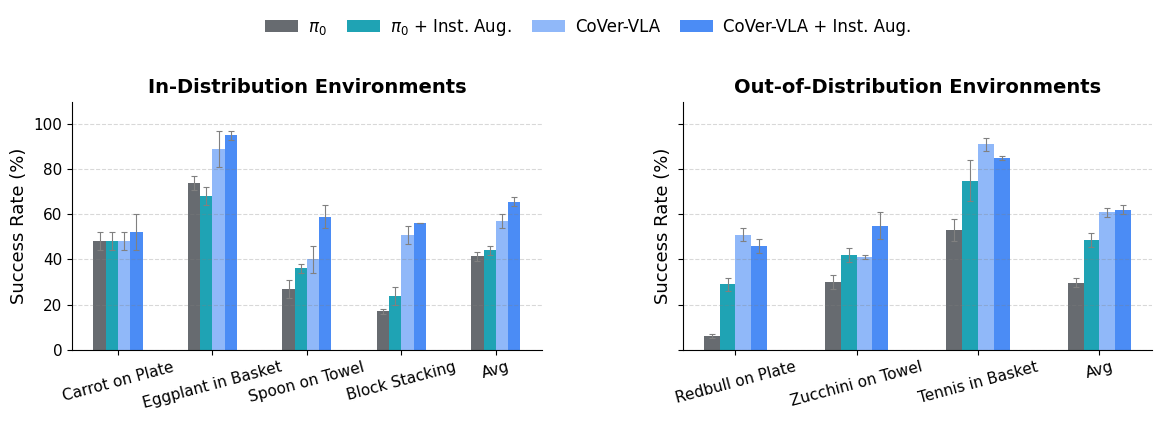

In [3]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ============================================================
# Font setup
# ============================================================
available_fonts = [f.name for f in fm.fontManager.ttflist]
if "Helvetica" in available_fonts:
    font_family = "Helvetica"
elif "Arial" in available_fonts:
    font_family = "Arial"
else:
    font_family = "DejaVu Sans"

plt.rcParams.update({
    "font.family": font_family,
    "font.size": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
})

# ============================================================
# Colors (Physical-Intelligence style)
# ============================================================
colors = [
    "#9AA0A7",  # RoboMonkey (baseline)
    "#5F6368",  # π0
    "#139EB0",  # π0 w/ Inst. Aug.
    "#017B84",  # π0 w/ random
    "#8AB4F9",  # CoVer-VLA
    "#4186F5"   # CoVer-VLA w/ Inst. Aug.
]

# ============================================================
# Data
# ============================================================
models = [
    r"RoboMonkey",
    r"$\pi_0$",
    r"$\pi_0$ + Inst. Aug.",
    r"$\pi_0$ + Rand. Reph.",
    r"CoVer-VLA",
    r"CoVer-VLA + Inst. Aug."
]

in_tasks = ["Carrot on Plate", "Eggplant in Basket", "Spoon on Towel", "Block Stacking", "Avg"]
out_tasks = ["Redbull on Plate", "Zucchini on Towel", "Tennis in Basket", "Avg"]

in_means = np.array([
    [ 0, 13, 10,  7,  7.5],
    [48, 74, 27, 17, 41.5],
    [48, 68, 36, 24, 44.0],
    [49, 78, 41,  1, 42.3],
    [48, 89, 40, 51, 57.0],
    [52, 95, 59, 56, 65.5],
])
in_stds = np.array([
    [0, 3, 1, 2, 1],
    [4, 3, 4, 1, 2],
    [4, 4, 2, 4, 2],
    [5, 3, 1, 1, 3],
    [4, 8, 6, 4, 3],
    [8, 2, 5, 0, 2],
])

out_means = np.array([
    [19, 10, 45, 24.7],
    [ 6, 30, 53, 29.7],
    [29, 42, 75, 48.7],
    [ 1,  7, 78, 28.7],
    [51, 41, 91, 61.0],
    [46, 55, 85, 62.0],
])
out_stds = np.array([
    [3, 5, 1, 2],
    [1, 3, 5, 2],
    [3, 3, 9, 3],
    [1, 2, 3, 2],
    [3, 1, 3, 2],
    [3, 6, 1, 2],
])

# ============================================================
# Remove RoboMonkey (idx 0) and π0 + Rand. Reph. (idx 3)
# Keep models: indices [1, 2, 4, 5]
# ============================================================
keep = [1, 2, 4, 5]

models = [models[i] for i in keep]
colors = [colors[i] for i in keep]

in_means = in_means[keep]
in_stds  = in_stds[keep]

out_means = out_means[keep]
out_stds  = out_stds[keep]


# ============================================================
# Plot helper
# ============================================================
def plot_env(ax, tasks, means, stds, title, show_legend=False):
    n_models, n_tasks = means.shape
    x = np.arange(n_tasks)
    width = 0.13

    for i in range(n_models):
        offset = (i - (n_models - 1) / 2) * width
        ax.bar(
            x + offset, means[i], width,
            yerr=stds[i],
            color=colors[i],
            capsize=2,
            alpha=0.95,
            error_kw=dict(lw=0.8, capthick=0.8, ecolor="gray"),
            label=models[i] if show_legend else None
        )

    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=15, ha="center")
    ax.set_ylim(0, 110)
    ax.set_ylabel("Success Rate (%)")
    ax.set_title(title, fontsize=14, weight="bold")
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.3)
    ax.set_facecolor("white")

# ============================================================
# 5. Balanced layout + single-row legend
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, gridspec_kw={"wspace": 0.3})

plot_env(axes[0], in_tasks, in_means, in_stds, "In-Distribution Environments", show_legend=True)
plot_env(axes[1], out_tasks, out_means, out_stds, "Out-of-Distribution Environments")

# # Move legend above both subplots in one row
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncol=len(models), loc="upper center", bbox_to_anchor=(0.5, 1.05))
# Move legend above both subplots in multi-column grid
handles, labels = axes[0].get_legend_handles_labels()

# Arrange legend manually in two columns, three rows
# order = [0, 1, 2, 3, 4, 5]  # keep order consistent with models
order = [0, 1, 2, 3]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=6,                   # two columns
    columnspacing=1.2,
    handletextpad=0.6,
    labelspacing=0.7,
    fontsize=12,
    frameon=False,
)

plt.subplots_adjust(left=0.07, right=0.97, top=0.80, bottom=0.18, wspace=0.35)
plt.savefig("plot.pdf", bbox_inches="tight")  # save current figure as PDF
plt.show()



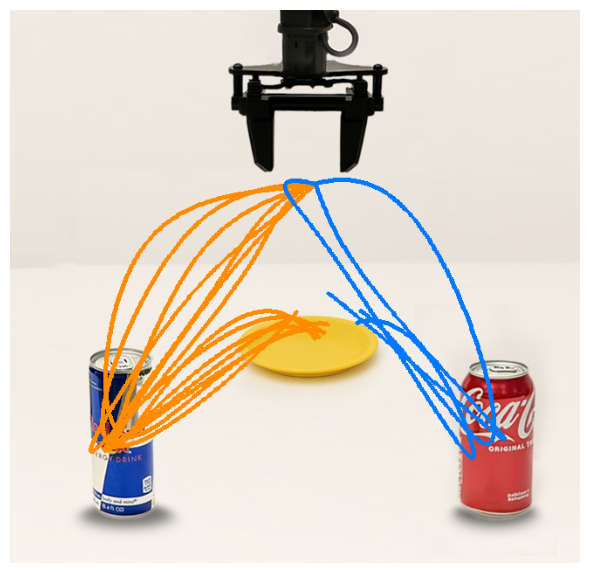

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Load image
img = cv2.imread("teaser.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ==========================================================
# Shared spline generator
# ==========================================================
def draw_bundle(img, base_points, num_trajs, color, thickness=3,
                pre_fan=50, post_jitter=20, end_jitter=10):
    for i in range(num_trajs):
        pts = base_points.copy().astype(float)
        offset_scale = np.linspace(-1, 1, num_trajs)[i]

        # Fan-out before contact
        pts[1, 0] += offset_scale * pre_fan
        pts[1, 1] -= abs(offset_scale) * 40
        pts[2, 0] += offset_scale * (pre_fan + 10)
        pts[2, 1] -= abs(offset_scale) * 60

        # Endpoint variation (target)
        pts[3] += np.random.randn(2) * np.array([end_jitter, end_jitter * 0.7])

        # Post-contact variation (after touch)
        pts[4] += np.random.randn(2) * np.array([post_jitter, post_jitter * 0.8])
        pts[5] += np.random.randn(2) * np.array([post_jitter * 1.2, post_jitter])

        # Slight jitter overall for natural spread
        pts[1:-1] += np.random.randn(*pts[1:-1].shape) * 4

        # Fit spline
        tck, _ = splprep([pts[:, 0], pts[:, 1]], s=0)
        u_fine = np.linspace(0, 1, 300)
        x, y = splev(u_fine, tck)

        # Draw
        for j in range(len(x) - 1):
            cv2.line(
                img,
                (int(x[j]), int(y[j])),
                (int(x[j + 1]), int(y[j + 1])),
                color=color,
                thickness=thickness,
            )
    return img


# ==========================================================
# Define base trajectories
# ==========================================================
gripper = [350, 200]

# → RedBull (orange)
points_redbull = np.array([
    gripper,
    [280, 250],
    [220, 330],
    [120, 500],  # RedBull
    [250, 390],
    [350, 370],
])
img = draw_bundle(img, points_redbull, num_trajs=7, color=(255, 140, 0))

# → Coke (blue)
points_coke = np.array([
    gripper,
    [360, 240],
    [400, 300],
    [550, 500],  # Coke
    [420, 380],
    [380, 360],
])
img = draw_bundle(img, points_coke, num_trajs=3, color=(0, 120, 255))

# ==========================================================
# Display
# ==========================================================
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()
